In [1]:
from matipo import SEQUENCE_DIR, GLOBALS_DIR
from matipo.sequence import Sequence
from matipo.util.autophase import autophase
from matipo.util.decimation import decimate
from matipo.util.fft import fft_reconstruction
from matipo.util.etl import deinterlace
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

# set matplotlib figure size, default is quite small
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

# progress_handler for Sequence.run() that simply prints the progress
def print_progress(p, l):
    print(p, '/', l)

### 2D Image using RARE/TSE

In [132]:
# load pulse sequence
seq = Sequence(SEQUENCE_DIR+'RARE.py')

seq.loadpar(GLOBALS_DIR+'shims.yaml')
seq.loadpar(GLOBALS_DIR+'frequency.yaml')
# seq.loadpar(GLOBALS_DIR+'hardpulse_90.yaml')
seq.loadpar(GLOBALS_DIR+'hardpulse_180.yaml')

seq.loadpar(GLOBALS_DIR+'softpulse_90_1.0mm.yaml')
g_slice = seq.par.g_slice*np.array([0, 0, 1.0]) # use g_slice loaded from softpulse_90 file

DECIMATION = 4

rot = Rotation.from_rotvec([0, np.pi/4, 0]) # rotate around y axis

seq.setpar(
    n_scans=4,
    
    f_slice_offset=3e3,
    
    g_slice=rot.apply(g_slice),
    
    n_ETL=64,
    
    # for 2D, just use phase_2 and set n_phase_1 to 1 with no gradient
    n_phase_1=1,
    g_phase_1=(0,0,0),
    
    # 64 phase steps
    n_phase_2=50,
    g_phase_2=rot.apply([0, 0.4, 0]),
    
    # oversample by a factor of 4 for flat filtering, 64*4 = 256 samples
    t_dw=8e-6,
    n_samples=50*DECIMATION,
    g_read=rot.apply([0.25, 0, 0]),
    
    # t_inv=1.2,
    # enable_IR=False,
    
    t_end=0.5,
    # enable_dummy_run=True
)

# set calculated read gradient pulse duration
seq.setpar(t_read=seq.par.t_dw*seq.par.n_samples)
# set phase  pulse duration so that the area is half the read pulse area
# seq.setpar(t_phase=seq.par.t_read/2)
seq.setpar(t_phase=np.abs(np.linalg.norm(seq.par.g_read)/np.linalg.norm(seq.par.g_phase_2))*seq.par.t_read/2)

# print out the parameter set for reference
print(seq.par)

# run sequence, progress_handler is optional
await seq.run(progress_handler=print_progress)

# deinterlace and decimate data
kdata = decimate(
    deinterlace(seq.data, seq.par.n_ETL, 1, seq.par.n_phase_2, seq.par.n_samples), 
    DECIMATION, axis=1)

ParameterSet(n_scans=4, f=15092999.285158932, a_90=0.06694990460206958, t_90=0.00075, f_slice_offset=3000.0, bw_90=6666.666666666668, a_180=0.705283649077263, t_180=3.2e-05, t_inv=0.001, t_dw=8e-06, n_samples=200, t_read=0.0015999999999999999, t_phase=0.0005, n_phase_1=1, n_phase_2=50, n_ETL=64, t_end=0.5, g_slice=array([0.56568542, 0.        , 0.56568542]), g_read=array([ 0.1767767,  0.       , -0.1767767]), g_phase_1=array([0., 0., 0.]), g_phase_2=array([0. , 0.4, 0. ]), t_spoil=0.001, g_spoil=array([0., 0., 0.]), t_grad_ramp=0.0001, n_grad_ramp=10, shim_x=0.19938959341968357, shim_y=0.15530707112894346, shim_z=-0.3504764784090593, shim_z2=-0.23593340857254402, shim_zx=-0.44922067929310977, shim_zy=0.056565639806096274, shim_xy=0.025663274020015628, shim_x2y2=0.22449191422732565, enable_IR=False, enable_dummy_run=False)
1 / 4
2 / 4
3 / 4
4 / 4


#### Raw Signal Plot

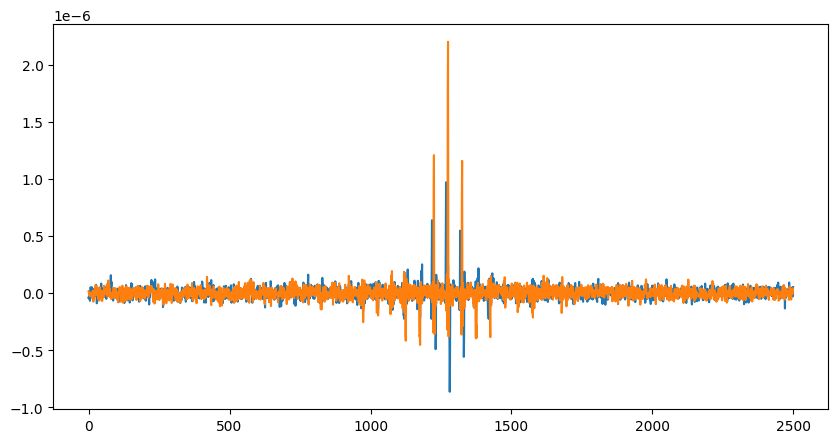

In [133]:
plt.plot(kdata.flatten().real)
plt.plot(kdata.flatten().imag)
plt.show()

#### K-Space and Image Plots

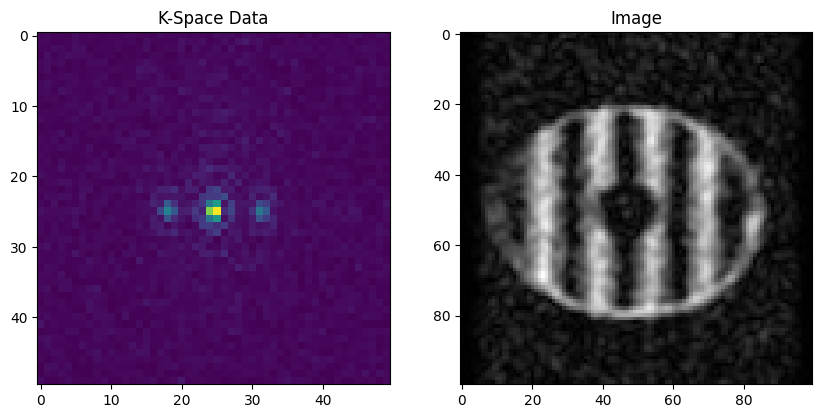

In [134]:
# use fourier reconstruction to get the 2D projection image
image = fft_reconstruction(kdata, gaussian_blur=1, upscale_factor=2)

# plot kspace data
plt.subplot(1, 2, 1)
plt.imshow(np.abs(kdata))
plt.title('K-Space Data')

# plot image data
plt.subplot(1, 2, 2)
plt.imshow(np.abs(image), cmap='gray')
plt.title('Image')

plt.show()